In [671]:
# import rasterio as rio
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import scipy
from scipy.ndimage import gaussian_filter
import random
from sklearn.metrics import mean_squared_error
from matplotlib import patches

# Automatically pick the surge front using centerline speed profiles

In [466]:
############# path to the centerline data #################
clinefolder = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/custom_autoRIFT_cline_data/filtered-north/PAPER_FIGURE/'
# clinefolder = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/custom_autoRIFT_cline_data/filtered-north/'
###########################################################

In [527]:
pd.to_datetime(mid_date)

Timestamp('2019-07-02 12:00:00')

In [533]:
df[pd.to_datetime(df.date) == pd.to_datetime(mid_date)]

,date,dist_km,sat,dt_days,mid_date,days_since


'2018-05-11'

In [546]:
len(frontpos)

0

In [552]:
for file in os.listdir(clinefolder):
    if file.startswith('') and file.endswith('.csv') and not file.endswith('s.csv'):
        # read in centerline velocity data (grab mid_date and satellite)
        v_df = pd.read_csv(clinefolder+file)
        [ds1, ds2, sat, chipsize] = file.split('_')
        
        # calculate mid_date
        date1 = datetime.datetime.strptime(str(ds1),'%Y%m%d')
        date2 = datetime.datetime.strptime(str(ds2),'%Y%m%d')
        dt = date2-date1; dt_days = dt.days
        mid_date = date1+(date2-date1)/2
        
        frontpos = df[df.date == str(pd.to_datetime(mid_date))[:10]].dist_km
        
        # only consider those in a certain date range
        if mid_date >= datetime.datetime(2020,3,1) and mid_date <= datetime.datetime(2020,7,1) and len(frontpos)>0: 
            if sat == 'S1':
                v_df = v_df[v_df.dist_km <= 20.0]
                speed = v_df.vmag
                dist = v_df.dist_km*1000
            else:
                v_df = v_df[v_df.dist_m/1000 <= 20.0] # only consider part of profile below the icefall
                speed = v_df.v
                dist = v_df.dist_m
            
            print(mid_date, np.nanmean(speed[dist/1000 >= float(frontpos)]))
                
#             print(mid_date, float(frontpos), np.nanmean(speed)/365)

2020-04-05 12:00:00 2156.9750708333336
2020-05-07 12:00:00 4183.672256666667
2020-06-06 12:00:00 4686.331883235294
2020-05-21 00:00:00 4168.957216
2020-04-28 12:00:00 3760.575746551724
2020-06-28 12:00:00 5622.524792105262
2020-05-12 12:00:00 4764.402413833333
2020-05-31 12:00:00 3414.740766666667
2020-03-17 00:00:00 1830.5292714285715
2020-03-08 12:00:00 1283.8833833333335


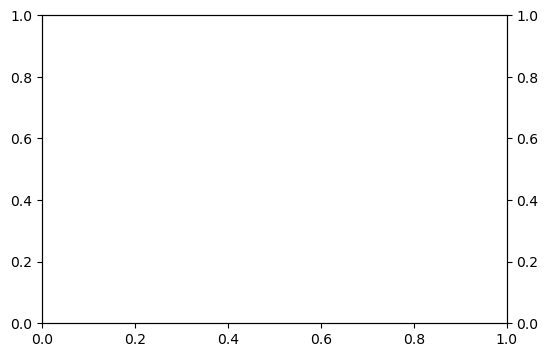

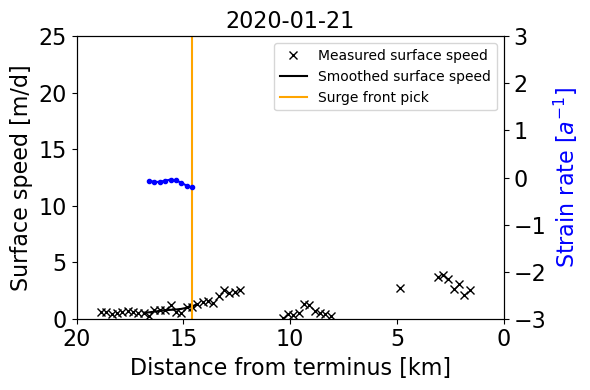

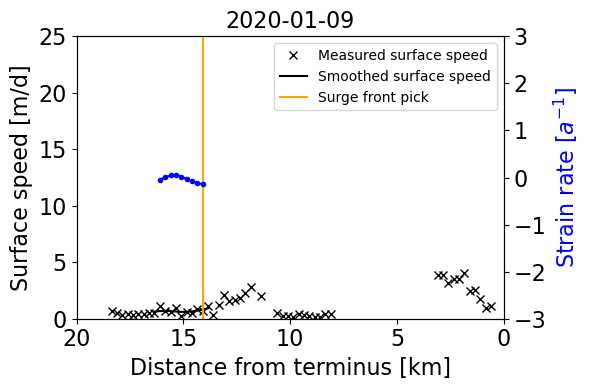

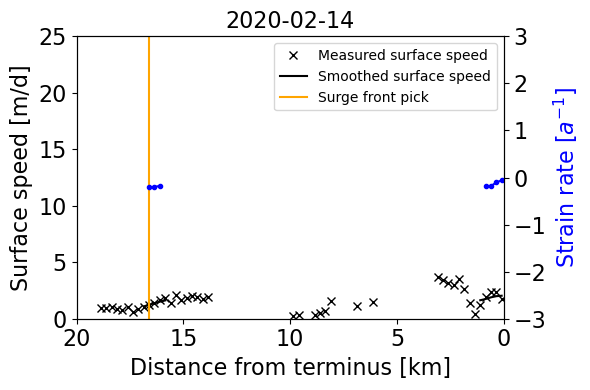

In [472]:
mid_dates = []; sats = []; dists = []; dts = []
fs=16
dx = 250 # horizontal spacing (250m)

for file in os.listdir(clinefolder):
    if file.startswith('') and file.endswith('.csv') and not file.endswith('s.csv'):
        # read in centerline velocity data (grab mid_date and satellite)
        v_df = pd.read_csv(clinefolder+file)
        [ds1, ds2, sat, chipsize] = file.split('_')
        
        # calculate mid_date
        date1 = datetime.datetime.strptime(str(ds1),'%Y%m%d')
        date2 = datetime.datetime.strptime(str(ds2),'%Y%m%d')
        dt = date2-date1; dt_days = dt.days
        mid_date = date1+(date2-date1)/2
        
        # only consider those in a certain date range
        if mid_date >= datetime.datetime(2020,1,1) and mid_date <= datetime.datetime(2020,10,1): 
            
            if sat == 'S1':
                v_df = v_df[v_df.dist_km <= 20.0]
                speed = v_df.vmag
                dist = v_df.dist_km*1000
            else:
                v_df = v_df[v_df.dist_m/1000 <= 20.0] # only consider part of profile below the icefall
                speed = v_df.v
                dist = v_df.dist_m
            
            # calculate smoothed velocity profile using a gaussian filter with st. dev of sigma
            sigma = 2
            v_smooth = gaussian_filter(speed/365, sigma)
            v_smooth_count = np.count_nonzero(~np.isnan(v_smooth)) # count how many data values in profile
            
            if v_smooth_count > len(v_df)*0.10: # if more than 60% of the profile remains, continue
                dist_km = np.array(dist)/1000
                # plot profile below icefall
                fig, ax = plt.subplots(1, figsize=(6,4))
                twinax = ax.twinx()
                ax.plot(dist_km, speed/365, 'kx') # raw data
                ax.plot(dist_km, v_smooth, 'k-') # smoothed profile
                ax.set_xlim(20,0) 
                ax.set_ylim(0,25)
                ax.set_xlabel('Distance from terminus [km]',fontsize=fs)
                ax.set_ylabel('Surface speed [m/d]',fontsize=fs)
                plt.title(str(mid_date)[0:10],fontsize=fs)

                # calculate 1D gradient in smoothed velocity along centerline and plot on the same figure
                v_grad = np.gradient(np.array(v_smooth), dx)*365 
                twinax.plot(dist_km, v_grad, 'b.-')

                # find the local global minimum v_grad
                idx = np.nanargmin(v_grad)
                surge_front_dist = dist_km[idx] # grab that distance from terminus
                
                # don't use really small gradients
                if True:
#                 if np.nanmin(v_grad) < -0.1:
                    # plot that distance as a vertical line on the map
                    ax.axvline(x = surge_front_dist, color = 'orange', label = 'axvline - full height')
                    ax.legend(['Measured surface speed','Smoothed surface speed', 'Surge front pick'],fontsize=fs-6)
                    twinax.set_ylabel('Strain rate [$a^{-1}$]', color='blue',fontsize=fs)
                    twinax.set_ylim(-3,3)
                    ax.tick_params(labelsize=fs); twinax.tick_params(labelsize=fs)
                    plt.tight_layout()
#                     plt.savefig('/Users/jukesliu/Documents/TURNER/DATA/figures/speedup_extent_picks/'+str(mid_date)[0:10]+'_'+sat+'.png', dpi=200)
                    plt.show()

                    mid_dates.append(mid_date); sats.append(sat); dists.append(surge_front_dist)
                    dts.append(dt_days)

In [248]:
# create a dataframe with surge front distances
surge_front_df = pd.DataFrame(list(zip(mid_dates, sats, dists, dts)),columns=['mid_date','satellite','dist_km', 'dt_days'])
surge_front_df = surge_front_df.drop(surge_front_df[surge_front_df.satellite == 'PS'].index)
surge_front_df = surge_front_df.sort_values(by='mid_date')
surge_front_df = surge_front_df[(surge_front_df.mid_date > datetime.datetime(2020,2,1))
                                & (surge_front_df.mid_date < datetime.datetime(2020,9,1))]
surge_front_df = surge_front_df.reset_index(drop=True)
surge_front_df = surge_front_df.drop(0) # drop the first LS point in 2020
surge_front_df = surge_front_df.reset_index(drop=True)
surge_front_df


,mid_date,satellite,dist_km,dt_days
0,2020-03-08 12:00:00,S2,18.60,5
1,2020-03-08 12:00:00,S2,18.35,5
2,2020-03-08 12:00:00,S2,18.10,5
3,2020-03-08 12:00:00,S2,17.85,5
4,2020-03-17 00:00:00,S2,18.10,12
5,2020-03-17 00:00:00,S2,18.10,12
6,2020-03-17 00:00:00,S2,18.10,12
7,2020-03-17 00:00:00,S2,15.85,12
8,2020-04-03 12:00:00,S2,9.35,3
9,2020-04-03 12:00:00,S2,9.10,3


/Users/jukesliu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


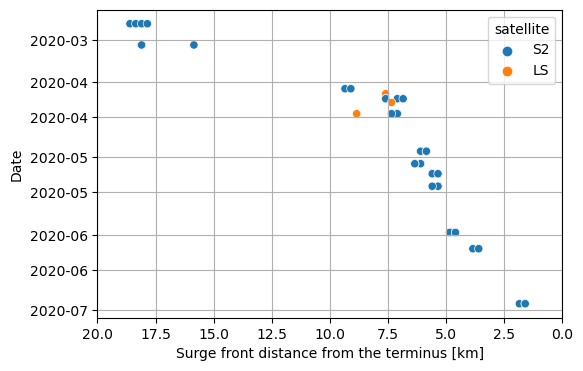

In [249]:
# replot surge front distance from terminus vs. date figure with vmap
import matplotlib.dates as mdates

# year = 2017
fig, ax = plt.subplots(1, figsize=(6,4))
sns.scatterplot(surge_front_df.dist_km, surge_front_df.mid_date, hue=surge_front_df.satellite)
ax.set_xlim(20,0)
ax.grid()
# ax.set_yticks([datetime.datetime(year,2,1),
#             datetime.datetime(year,4,1),
#             datetime.datetime(year,6,1), 
#             datetime.datetime(year,8,1),            
#            ])
ax.yaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.yaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_xlabel('Surge front distance from the terminus [km]')
ax.set_ylabel('Date')
plt.gca().invert_yaxis()
plt.show()

In [112]:
# year = 2020
# year_df = surge_front_df[(surge_front_df.mid_date > datetime.datetime(year, 3, 1)) & 
#                (surge_front_df.mid_date < datetime.datetime(year, 9, 1))]
# year_df
# print(np.array(year_df.dist_km))

In [113]:
# np.nanmin(year_df.dist_km)

# Model surge front distance over time to calculate propagation speed

In [250]:
# convert datetimes to days after February 1, 2020
days_since = []
for idx, row in surge_front_df.iterrows():
    dt = row.mid_date - pd.datetime(2020,2,1)
    secs_per_day = 24*60*60    # hours * mins * secs
    dt_days = dt.total_seconds()/secs_per_day
#     print(dt_days)
    days_since.append(dt_days)
surge_front_df['days_since'] = days_since
surge_front_df = surge_front_df.groupby(by='mid_date', as_index=False).mean() # calculate mean estimate for each date
df = surge_front_df

<ipython-input-250-29d2066c1a6d>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dt = row.mid_date - pd.datetime(2020,2,1)


In [224]:
# df = df.reset_index(drop=True)
# df = df.drop(columns='index')

In [257]:
# RUN THIS TO FILTER OUT DIPS UNTIL NOTHING IS LEFT
for idx, row in df.iterrows():
    # look two ahead
    if idx+2 < len(df):
        dist1 = df.loc[idx,'dist_km']
        dist2 = df.loc[idx+1,'dist_km']
        dist3 = df.loc[idx+2,'dist_km']
        
        if (dist1 > dist2) & (dist1 > dist3) & (dist2 > dist3):
            continue # then they are sequential, good, skip
        else:
            print(dist1, dist2, dist3)
            # drop the middle
            df = df.drop(idx+1)
            print(dist2, 'dropped')
            break
            
df = df.reset_index(drop=True)
df

,mid_date,dist_km,dt_days,days_since
0,2020-03-08 12:00:00,18.2250,5.0,36.5
1,2020-03-17 00:00:00,17.5375,12.0,45.0
2,2020-04-03 12:00:00,9.2250,3.0,62.5
3,2020-04-05 12:00:00,7.6000,9.0,64.5
4,2020-04-13 12:00:00,7.5500,7.0,72.5
5,2020-05-03 12:00:00,6.2250,3.0,92.5
6,2020-05-07 12:00:00,5.4750,5.0,96.5
7,2020-05-12 12:00:00,5.4125,5.0,101.5
8,2020-05-31 00:00:00,4.7250,8.0,120.0
9,2020-06-06 12:00:00,3.6625,5.0,126.5


In [464]:
# adjust 2020-03-17 and 2020-05-03
df.loc[1, 'dist_km'] = 15 # 2020-03-17 
df.loc[5, 'dist_km'] = 6.2250 # 2020-05-03

In [553]:
# read in manual df
df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/SURGE-PROPAGATION/manual_surge_propagation.csv')
df['mid_date'] = pd.to_datetime(df.date)
days_since = []
for idx, row in df.iterrows():
    dt = row.mid_date - pd.datetime(2020,2,1)
    secs_per_day = 24*60*60    # hours * mins * secs
    dt_days = dt.total_seconds()/secs_per_day
    days_since.append(dt_days)
df['days_since'] = days_since
df

<ipython-input-553-d47b26dd72ea>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dt = row.mid_date - pd.datetime(2020,2,1)


,date,dist_km,sat,dt_days,mean_speed_ma,mid_date,days_since
0,2020-03-08,18.50,S2,5,1283.9,2020-03-08,36.0
1,2020-03-17,16.00,S2,12,1830.5,2020-03-17,45.0
2,2020-04-05,8.00,LS,9,2157.0,2020-04-05,64.0
3,2020-04-28,5.50,S2,7,3760.6,2020-04-28,87.0
4,2020-05-07,5.00,S2,5,4183.7,2020-05-07,96.0
5,2020-05-12,4.25,S2,5,4764.4,2020-05-12,101.0
6,2020-05-21,4.00,S2,12,4168.9,2020-05-21,110.0
7,2020-05-31,3.75,LS,7,3414.7,2020-05-31,120.0
8,2020-06-06,3.00,S2,5,4686.3,2020-06-06,126.0
9,2020-06-28,1.00,S2,5,5622.5,2020-06-28,148.0


In [579]:
from matplotlib.ticker import FormatStrFormatter

# add in weather data plot (daily_average):
def F_to_C(f_array):
    # converts array of temperatures in Farenheit to Celsuis
    f_array = np.array(f_array) # make sure it's a numpy array
    c_array = (f_array - 32)*5/9
    return c_array

weather_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/WEATHER/wx_from_crrel_202209/wx_Haenke_2014_2022_nogap.csv')
weather_df.AKDT = pd.to_datetime(weather_df.AKDT) # convert to datetime
weather_df.head()

,GMT,Temp-AIR1,Temp-AIR2,Temp-AVG,AKDT
0,2013-01-01 00:00:00,NaN,NaN,NaN,2012-12-31 16:00:00
1,2013-01-01 00:15:00,NaN,NaN,NaN,2012-12-31 16:15:00
2,2013-01-01 00:30:00,NaN,NaN,NaN,2012-12-31 16:30:00
3,2013-01-01 00:45:00,NaN,NaN,NaN,2012-12-31 16:45:00
4,2013-01-01 01:00:00,NaN,NaN,NaN,2012-12-31 17:00:00


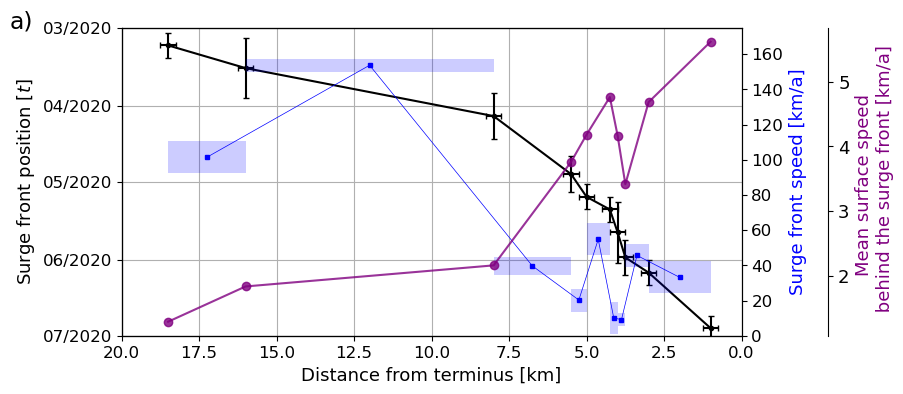

Mean surge propagation speed: 51.982833034129754


In [702]:
# plot
fs = 13
fig, ax = plt.subplots(1, figsize=(8,4))

# PLOT SuRGE FRONT POSITIONS
ax.scatter(df.dist_km, df.mid_date, marker='.', color='black')
ax.errorbar(df.dist_km, df.mid_date, xerr=0.25, yerr=pd.to_timedelta(df.dt_days, unit='D'),capsize=2, color='black')
# ax.plot(dist_smooth, df.days_since)
ax.set_ylabel('Surge front position [$t$]', color='black', fontsize=fs)
# ax.set_ylim()

ax.set_yticks([datetime.datetime(2020,3,1), datetime.datetime(2020,4,1),
            datetime.datetime(2020,5,1), datetime.datetime(2020,6,1),
            datetime.datetime(2020,7,1), 
            datetime.datetime(2020,9,1),            
           ],labelsize=fs)
ax.set_ylim([datetime.datetime(2020,3,1), datetime.datetime(2020,7,1),])
ax.yaxis.set_major_formatter(mdates.DateFormatter("%m/%Y"))
ax.yaxis.set_minor_formatter(mdates.DateFormatter("%m/%Y"))
ax.tick_params(labelsize=fs-1)
plt.gca().invert_yaxis()
ax.grid()

vfront_kmd = np.diff(df.dist_km)/np.diff(df.days_since)
vfront_kma = np.abs(vfront_kmd*365)
dist_mid = np.diff(df.dist_km,append=0)/2 + df.dist_km

# PLOT SURGE FRONT VELOCITY AS PATCHES INSTEAD:
twinax = ax.twinx()
n = 0
for vfront_val in vfront_kma:
    dist_change = df.dist_km[n+1]-df.dist_km[n]
    halfwidth = dist_change/2
    verr = np.sqrt((0.25**2)/(df.dt_days[n]**2))*365/2
    pw = halfwidth*2
    ph = verr*2
    
    patch = patches.Rectangle((dist_mid[n]-halfwidth, vfront_val-verr),pw,ph,facecolor='blue',alpha=0.2)
    twinax.add_patch(patch)
    n+=1    
twinax.plot(dist_mid[:-1], vfront_kma, 'bs-', markersize=3, linewidth=0.5)
avg_v = np.nanmean(vfront_kma)
# twinax.plot([20, 0], [avg_v, avg_v], 'b--',linewidth=1)
twinax.set_ylim(0,175)

twinax.set_ylabel('Surge front speed [km/a]', color='blue', fontsize=fs)
twinax.tick_params(labelsize=fs-1)
# twinax.annotate(str(int(np.round(avg_v))),(1,avg_v+5),color='blue',fontsize=fs)

# PLOT SURFACE SPEED - 3rd y-axis
twin2 = ax.twinx()
twin2.spines.right.set_position(("axes", 1.14))
twin2.plot(df.dist_km, df.mean_speed_ma/1000, 'o-',color='purple',alpha=0.8)
twin2.tick_params(labelsize=fs)
twin2.set_ylabel('Mean surface speed \n behind the surge front [km/a]',fontsize=fs, color='purple')

plt.gca().invert_xaxis()
ax.set_xlim(20,0)
ax.set_xlabel('Distance from terminus [km]', fontsize=fs)
plt.text(-0.18, 1, 'a)',fontsize=fs+4,transform = ax.transAxes) # top left label
plt.show()
print('Mean surge propagation speed:',avg_v)

In [485]:
# mid distances
dist_mid = np.diff(df.dist_km,append=0)/2 + df.dist_km

# recalculate mid_date using days_since and then converting back into datetimes
date_mids = []
for i in range(0, len(df.mid_date)-1):
    dt = df.loc[i+1, 'mid_date'] - df.loc[i, 'mid_date']
    date_mids.append(df.loc[i, 'mid_date']+dt/2)
    
# add date uncerainties from neighboring dates
day_uncertainty = []
for i in range(0, len(df.dt_days)-1):
    day_uncertainty.append(np.max([df.dt_days[i],df.dt_days[i+1]]))
date_uncertainty = pd.to_timedelta(day_uncertainty, unit='D') # convert to timedeltas

In [634]:
# weather data
from matplotlib.ticker import FormatStrFormatter

# add in weather data plot (daily_average):
def F_to_C(f_array):
    # converts array of temperatures in Farenheit to Celsuis
    f_array = np.array(f_array) # make sure it's a numpy array
    c_array = (f_array - 32)*5/9
    return c_array

weather_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/WEATHER/wx_from_crrel_202209/wx_Haenke_2014_2022_nogap.csv')
weather_df.AKDT = pd.to_datetime(weather_df.AKDT) # convert to datetime
# weather_df.head()

# weekly (or monthly average)
weekly_df = weather_df.groupby(pd.Grouper(key='AKDT', freq='W')).mean() 
monthly_df = weather_df.groupby(pd.Grouper(key='AKDT', freq='M')).mean() 

# CORRECT WITH LAPSE RATE:
LAPSE_RATE = -6 # degrees C/K per km
ELEV_HIGH = 1092
ELEV_LOW = 0
WXCOLOR='orange'

In [685]:
len(date_mids)

9

2020-03-12 12:00:00 2.5
2020-03-26 12:00:00 6.0
2020-04-16 12:00:00 4.5
2020-05-02 12:00:00 3.5
2020-05-09 12:00:00 2.5
2020-05-16 12:00:00 2.5
2020-05-26 00:00:00 6.0
2020-06-03 00:00:00 3.5
2020-06-17 00:00:00 2.5


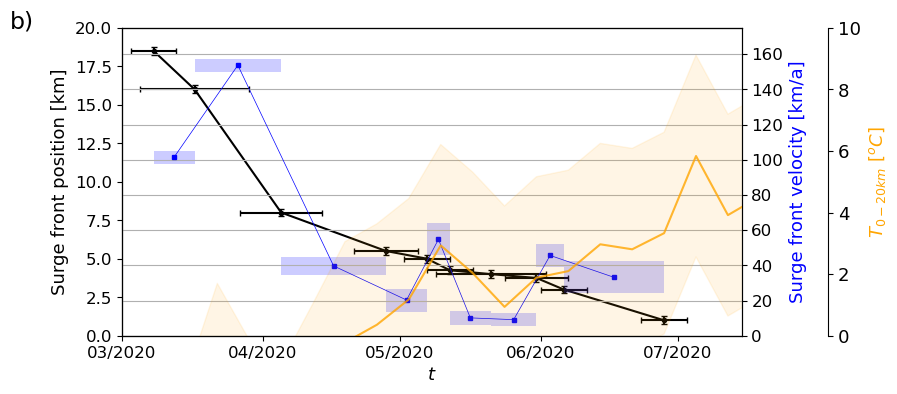

Mean surge propagation speed: 51.982833034129754


In [700]:
# plot
fs = 13
fig, ax = plt.subplots(1, figsize=(8,4))

# Plot surge front positinos
ax.scatter(df.mid_date, df.dist_km, marker='.', color='black')
ax.errorbar(df.mid_date, df.dist_km, yerr=0.25, xerr=pd.to_timedelta(df.dt_days, unit='D'),capsize=2, color='black')
# ax.plot(dist_smooth, df.days_since)
ax.set_ylabel('Surge front position [km]', color='black', fontsize=fs)
ax.set_ylim(0,20)

ax.set_xticks([datetime.datetime(2020,3,1), datetime.datetime(2020,4,1),
            datetime.datetime(2020,5,1), datetime.datetime(2020,6,1),
            datetime.datetime(2020,7,1), datetime.datetime(2020,8,1),
            datetime.datetime(2020,9,1),            
           ],labelsize=fs)
ax.set_xlim([datetime.datetime(2020,3,1), datetime.datetime(2020,7,15),])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%Y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m/%Y"))
ax.tick_params(labelsize=fs-1)
# plt.gca().invert_xaxis()
# ax.grid()

# PLOT SURGE FRONT VELOCITY AS PATCHES INSTEAD:
vfront_kmd = np.diff(df.dist_km)/np.diff(df.days_since)
vfront_kma = np.abs(vfront_kmd*365)
twinax = ax.twinx()

n=0
for date_mid in date_mids:
    dt = df.mid_date[n+1]-df.mid_date[n]
    halfwidth = dt/2
#     dist_change = df.dist_km[n+1]-df.dist_km[n]
#     halfwidth = pd.to_timedelta(df.dt_days[n]/2, unit='D')
    verr = np.sqrt((0.25**2)/(day_uncertainty[n]**2))*365/2
    pw = halfwidth*2
    ph = verr*2
    print(date_mid, df.dt_days[n]/2)
    
    patch = patches.Rectangle((date_mid-halfwidth, vfront_kma[n]-verr),pw,ph,facecolor='blue',alpha=0.2)
    twinax.add_patch(patch)
    n+=1    
    
twinax.plot(date_mids,vfront_kma, 'bs-', markersize=3, linewidth=0.5)
# twinax.errorbar(date_mids, vfront_kma, xerr=date_uncertainty/2, 
#                 yerr=np.sqrt((0.25**2)/(np.array(day_uncertainty)**2))*365,
#                 color='b', linestyle='',capsize=2)
avg_v = np.nanmean(vfront_kma)
# twinax.plot([datetime.datetime(2020,3,1), datetime.datetime(2020,8,1)], [avg_v, avg_v], 'b--', linewidth=1)
# twinax.annotate(str(int(np.round(avg_v))),(0.5,avg_v+5),color='blue',fontsize=fs)
twinax.set_ylim(0,175)
twinax.tick_params(labelsize=fs-1)
twinax.set_ylabel('Surge front velocity [km/a]', color='b', fontsize=fs)
twinax.grid()

# PLOT TEMPERATURE - 3rd y-axis
temps_high = F_to_C(weekly_df['Temp-AVG'])+(ELEV_LOW/1000)*LAPSE_RATE 
temps_mean = F_to_C(weekly_df['Temp-AVG'])+(((ELEV_HIGH+ELEV_LOW)/2)/1000)*LAPSE_RATE 
temps_low = F_to_C(weekly_df['Temp-AVG'])+(ELEV_HIGH/1000)*LAPSE_RATE 
twin2 = ax.twinx()
twin2.spines.right.set_position(("axes", 1.14))
twin2.fill_between(weekly_df.index, temps_low, temps_high, color=WXCOLOR, alpha=0.1)
twin2.plot(weekly_df.index, temps_mean, color=WXCOLOR, alpha=0.8)
# twin2.plot(date_mids, (df.mean_speed_ma/365)[1:], 'o-',color='black',alpha=0.5)
twin2.tick_params(labelsize=fs)
twin2.set_ylabel('$T_{0-20km}$ [$^o C$]',fontsize=fs, color=WXCOLOR)
twin2.set_ylim(0,10)

ax.set_xlabel('$t$', fontsize=fs)
plt.text(-0.18, 1, 'b)',fontsize=fs+4,transform = ax.transAxes) # top left label
# plt.gca().invert_xaxis()
# ax.set_xlim(20,0)
# ax.set_xlabel('Distance from the terminus [km]', fontsize=fs)
plt.show()
print('Mean surge propagation speed:',avg_v)

In [638]:
np.nanmax(temps_low)

19.673

### Linear model for all data

Average surge front propagtion speed: 49.253502895721 km/a


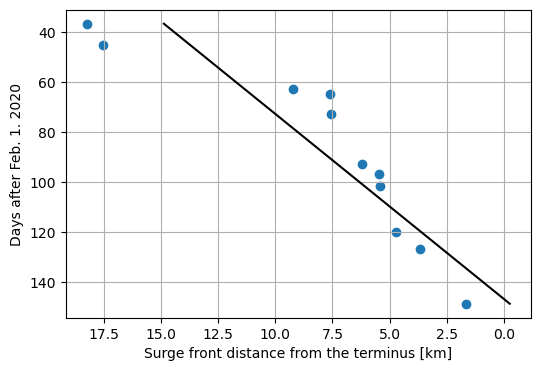

In [288]:
# ONE MODEL
# run linear regression on entire time series
regstats = scipy.stats.linregress(df.days_since, df.dist_km)
prop_speed = regstats.slope*365
print('Average surge front propagtion speed:', abs(prop_speed), 'km/a')

# create time array
interval = 0.5
t_array = np.arange(df.days_since[0], df.days_since[len(df)-1]+interval, interval)

# plot
fig, ax = plt.subplots(1, figsize=(6,4))
ax.scatter(df.dist_km, df.days_since)
ax.plot(t_array*regstats.slope + regstats.intercept,t_array, 'k-')
plt.gca().invert_yaxis(); plt.gca().invert_xaxis()
plt.ylabel('Days after Feb. 1. 2020')
plt.xlabel('Surge front distance from the terminus [km]')
plt.grid()
plt.show()


In [289]:
def split_dataset(df,train_frac=0.9):
    import numpy as np
    import pandas as pd
    import random
    # takes a dataframe and splits it randomly into training and testing datasets
    # with fractions dictated by train_frac (default=0.9, i.e., 90%)
    # returns two separate dataframes one for training and one for testing
    
    df = df.reset_index() # make sure we start with fresh, ordered indices
    n_training_samples = int(len(df)*0.9) # grab number of training samples, based on total number of samples
    
    train_idx = random.sample(list(df.index), n_training_samples) # grab training indices
    test_idx = list(set(df.index).difference(train_idx)) # grab testing indices (not training indices)
    
    # grab training and testing subsets of the dataframe
    test_df = df.iloc[test_idx]
    train_df = df.iloc[train_idx]
    return train_df, test_df

In [296]:
# MONTE CARLO FOR 1000 models using 90/10 splits
# create time array
interval = 0.5
buffer = 5 # days
t_array = np.arange(df.days_since[0]-buffer, df.days_since[len(df)-1]+buffer, interval)

# start figure
fig, ax = plt.subplots(1, figsize=(6,4))
plt.gca().invert_yaxis(); plt.gca().invert_xaxis()
plt.ylabel('Days after Feb. 1. 2020')
plt.xlabel('Surge front distance from the terminus [km]')
plt.grid()
ax.set_ylim(df.days_since[len(df)-1]+buffer,df.days_since[0]-buffer)

# begin Monte Carlo
n = 5000
model_intercepts = []; model_slopes = []; model_RMSEs = []
for ni in np.arange(0,n):
    [training_df, testing_df] = split_dataset(df, 0.9) # split the data 90/10
    
    # linear regression with 90 split and plot
    regstats = scipy.stats.linregress(training_df.days_since, training_df.dist_km)
    ax.plot(t_array*regstats.slope + regstats.intercept,t_array,'-',color='gray',alpha=0.005) # plot the model
    
    # calculate RMSE from testing dataset
    test_model = np.array(testing_df.days_since*regstats.slope + regstats.intercept)
    RMSE = mean_squared_error(testing_df.dist_km, test_model, squared=False)
    
    # store values:
    model_intercepts.append(regstats.intercept)
    model_slopes.append(regstats.slope)
    model_RMSEs.append(RMSE) 
    
# calculate st. dev of all slopes and mean slope, intercept
mean_slope = np.nanmean(model_slopes)
slope_std = np.nanstd(model_slopes)
mean_intercept = np.nanmean(model_intercepts)
prop_speed = mean_slope*365 # km/yr

# plt.title('Avg. surge propagtion speed: '+str(int(abs(prop_speed)))+' km/a')
ax.plot(t_array*mean_slope+mean_intercept, t_array, 'k-') # plot mean model on figure
ax.errorbar(df.dist_km, df.days_since, xerr=0.25, yerr=df.dt_days, linestyle='')
ax.scatter(df.dist_km, df.days_since, '.')
plt.show()

ValueError: s must be a scalar, or float array-like with the same size as x and y

In [90]:
# surge_front_df

,mid_date,satellite,dist_km,days_since
0,2013-06-13 12:00:00,LS,18.35,-2423.5
1,2013-06-13 12:00:00,LS,18.10,-2423.5
2,2013-06-13 12:00:00,LS,18.10,-2423.5
3,2013-06-13 12:00:00,LS,18.10,-2423.5
4,2013-06-29 12:00:00,LS,18.35,-2407.5
...,...,...,...,...
355,2020-06-06 12:00:00,S2,3.60,126.5
356,2020-06-28 12:00:00,S2,1.85,148.5
357,2020-06-28 12:00:00,S2,1.60,148.5
358,2020-06-28 12:00:00,S2,1.60,148.5


### Linear model for different data splits

In [94]:
# linear regression on different splits of the data
df = surge_front_df[(surge_front_df.mid_date > datetime.datetime(2020,2,1)) & 
                   (surge_front_df.mid_date < datetime.datetime(2020,9,1))] # reset df here
split_at_dist = 7.5 # km marking to split data on

df1 = df[df.dist_km < split_at_dist]; df1 = df1.reset_index()
df2 = df[df.dist_km >= split_at_dist]; df2 = df2.reset_index()

In [95]:
df

,mid_date,satellite,dist_km,days_since
308,2020-03-08 00:00:00,LS,10.85,36.0
309,2020-03-08 12:00:00,S2,18.60,36.5
310,2020-03-08 12:00:00,S2,18.35,36.5
311,2020-03-08 12:00:00,S2,18.10,36.5
312,2020-03-08 12:00:00,S2,17.85,36.5
313,2020-03-17 00:00:00,S2,15.85,45.0
314,2020-03-17 00:00:00,S2,18.10,45.0
315,2020-03-17 00:00:00,S2,18.10,45.0
316,2020-03-17 00:00:00,S2,18.10,45.0
317,2020-04-03 12:00:00,S2,9.10,62.5


In [98]:
# df2 = df2.drop(0)
# df = df.drop(0)

In [100]:
df

,index,mid_date,satellite,dist_km,days_since
1,309,2020-03-08 12:00:00,S2,18.60,36.5
2,310,2020-03-08 12:00:00,S2,18.35,36.5
3,311,2020-03-08 12:00:00,S2,18.10,36.5
4,312,2020-03-08 12:00:00,S2,17.85,36.5
5,313,2020-03-17 00:00:00,S2,15.85,45.0
6,314,2020-03-17 00:00:00,S2,18.10,45.0
7,315,2020-03-17 00:00:00,S2,18.10,45.0
8,316,2020-03-17 00:00:00,S2,18.10,45.0
9,317,2020-04-03 12:00:00,S2,9.10,62.5
10,318,2020-04-03 12:00:00,S2,9.10,62.5


Avg. surge propagtion speed: 23.964985198902532 km/a, +- 0.44614954998124345
Avg. surge propagtion speed: 130.3609888493426 km/a, +- 4.368613161587791


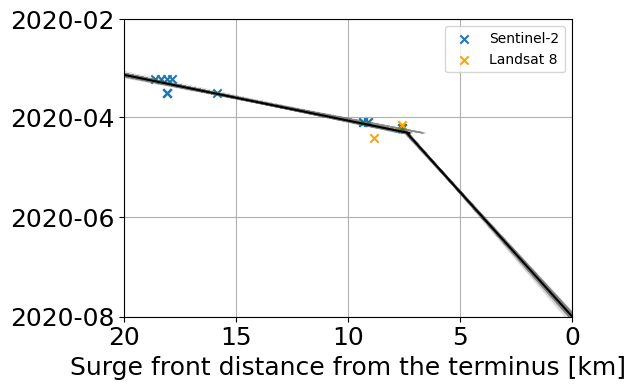

In [101]:
# start figure
fs=18
fig, ax = plt.subplots(1, figsize=(6,4))
# plt.ylabel('Days after Feb. 1, 2020')
plt.xlabel('Surge front distance from the terminus [km]', fontsize=fs)
plt.grid()

# plot original data
ax.scatter(df.dist_km[df.satellite == 'S2'], 
            df.mid_date[df.satellite == 'S2'], marker='x') 
ax.scatter(df.dist_km[df.satellite == 'LS'], 
            df.mid_date[df.satellite == 'LS'], marker='x', color='orange')    
ax.legend(['Sentinel-2','Landsat 8'])

# for each split
for df in [df1, df2]:
    # create the tarray
    interval = 0.5
    buffer = 0 # days
    
    if np.max(df.dist_km) <= split_at_dist:
        # for the slower split, use the latter half of the t_array
        t_array = np.arange(70, 182, interval)
    else:
        # for the faster split, use the first half of the t_array
        t_array = np.arange(1, 70, interval)
    # convert t_array to datetimes
    dt_array = []
    for t in t_array:
        dt = datetime.datetime(2020,2,1) + datetime.timedelta(t)
        dt_array.append(dt)
        
    # begin Monte Carlo
    n = 1000
    model_intercepts = []; model_slopes = []; model_RMSEs = []
    for ni in np.arange(0,n):
        [training_df, testing_df] = split_dataset(df, 0.9) # split the data 90/10

        # linear regression with 90 split and plot
        regstats = scipy.stats.linregress(training_df.days_since, training_df.dist_km)
        ax.plot(t_array*regstats.slope + regstats.intercept,dt_array,'-',color='gray',alpha=0.005) # plot the model

        # calculate RMSE from testing dataset
        test_model = np.array(testing_df.days_since*regstats.slope + regstats.intercept)
        RMSE = mean_squared_error(testing_df.dist_km, test_model, squared=False)

        # store values:
        model_intercepts.append(regstats.intercept)
        model_slopes.append(regstats.slope)
        model_RMSEs.append(RMSE) 
    
    model_results_df = pd.DataFrame(list(zip(model_RMSEs, model_slopes, model_intercepts)),
                                    columns=['rmse', 'slope','intercept'])
    
    # calculate st. dev of all slopes and mean slope, intercept
    mean_slope = np.nanmean(model_results_df.slope)
    slope_std = np.nanstd(model_results_df.slope)
    mean_intercept = np.nanmean(model_results_df.intercept)
    prop_speed = mean_slope*365 # km/yr

    print('Avg. surge propagtion speed: '+str(abs(prop_speed))+' km/a, +- '+str(slope_std*365))
    ax.plot(t_array*mean_slope+mean_intercept, dt_array, 'k-') # plot mean model on figure

ax.set_yticks([datetime.datetime(2020,2,1),
            datetime.datetime(2020,4,1),
            datetime.datetime(2020,6,1), 
            datetime.datetime(2020,8,1),            
           ],labelsize=fs)
ax.set_ylim([datetime.datetime(2020,2,1), datetime.datetime(2020,8,1),])
ax.yaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.yaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))
ax.tick_params(labelsize=fs)
# sns.scatterplot(surge_front_df.dist_km, surge_front_df.days_since, hue=surge_front_df.satellite) # plot original data    
plt.gca().invert_yaxis()
# plt.ylim(150,30)
plt.xlim(20,0)
plt.tight_layout()
plt.savefig('/Users/jukesliu/Documents/TURNER/DATA/figures/surge_propagation_speed_models.png',dpi=300)
plt.show()


In [71]:
import scipy